Anomaly Detection
===
>  Includes the anomaly detection algorithm, i.e. the prediction model, the loss functions and the anomaly score calculation and classification, as well as the metric computation.

In [148]:
#| default_exp anomaly.detect

In [149]:
#| hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
#| hide
from nbdev.showdoc import *

In [151]:
#| export
from fastai.basics import *
from pympp.process import *
from fastai.callback.all import *
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from fastai.tabular.model import get_emb_sz

## Only Control-flow 

In [152]:
log_name='pdc_2020_0101100'

In [153]:
log = import_log(f'./data/logs/csv/dapnn_ds/PDC2020_training/{log_name}.csv.gz')
log.head(20)

,activity,event_id
trace_id,,
trace 1,###start###,0
trace 1,t31,1
trace 1,t41,2
trace 1,t26,3
trace 1,t36,4
trace 1,t44,5
trace 1,t54,6
trace 1,t33,7
trace 1,t23,8


Create PPObj with vocab and dataloaders


In [154]:
#| export
def training_dl(log,cat_names='activity',seed=45,ws=5,bs=32):
    categorify=Categorify()

    o=PPObj(log,procs=categorify,cat_names=cat_names,y_names=cat_names,splits=split_traces(log,seed=seed))
    dls=o.get_dls(windows=partial(windows_fast,ws=ws),bs=bs)
    return o,dls,categorify



In [155]:
o,dls,categorify = training_dl(log)

In [156]:
x,y= dls.one_batch()

 Define Deep Learning Model

In [157]:
#| export
class ControlFlowModel(torch.nn.Module) :
    def __init__(self, o) :
        super().__init__()
        hidden=25
        vocab_act=len(o.procs.categorify['activity'])
        emb_dim_act = int(np.sqrt(vocab_act))+1

        self.emb_act = nn.Embedding(vocab_act,emb_dim_act)
        
        self.lstm_act = nn.LSTM(emb_dim_act, hidden, batch_first=True, num_layers=2)

        self.linear_act = nn.Linear(hidden, vocab_act)

    def forward(self, xcat):
        xcat=xcat[:,0]
        x_act=xcat
        x_act = self.emb_act(x_act)
        x_act,_ = self.lstm_act(x_act)
        x_act = x_act[:,-1]
        x_act = self.linear_act(x_act)
        return x_act

In [158]:
m=ControlFlowModel(o)


In [159]:
pred=m(x.cpu())

In [160]:
y[0].cpu()

tensor([20, 14, 20, 24, 10, 19, 23, 18, 23, 14, 14, 15, 14,  6, 19, 12, 14,  8,
        23, 16, 17, 10, 22, 13,  6, 26, 13, 14, 11, 19,  6, 15])

In [161]:
squeeze_cross_entropy = lambda x,y:F.cross_entropy(x,y[0])
squeeze_accuracy =lambda x,y:accuracy(x,y[0])


In [162]:
squeeze_cross_entropy(pred.cuda(),y),squeeze_accuracy(pred.cuda(),y)

(tensor(3.2628, device='cuda:0', grad_fn=<NllLossBackward>),
 TensorBase(0.1875, device='cuda:0'))

Define Training Loop and Helper Functions

In [163]:
#| export

class HideOutput:
    'A utility function that hides all outputs in a context'
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        
def training_loop(learn,epoch,print_output,lr_find):
    '''
    Basic training loop that uses learning rate finder and one cycle training. 
    See fastai docs for more information
    '''
    if lr_find:
        lr=np.median([learn.lr_find(show_plot=print_output)[0] for i in range(5)])
        learn.fit_one_cycle(epoch,float(lr))
    else: learn.fit(epoch,0.01)
        
def train_validate(dls,m,metrics=accuracy,loss=F.cross_entropy,epoch=20,print_output=True,model_dir=".",lr_find=True,
                   patience=5,min_delta=0.005,show_plot=True,store_path='tmp',model_name='.model'):
    '''
    Trains a model on the training set with early stopping based on the validation loss.
    Afterwards, applies it to the test set.
    '''
    cbs = [
      EarlyStoppingCallback(monitor='valid_loss',min_delta=min_delta, patience=patience),
      SaveModelCallback(fname=model_name),
      ]
    learn=Learner(dls, m, path=store_path, model_dir=model_dir, loss_func=loss ,metrics=metrics,cbs=cbs)

    if print_output:
        training_loop(learn,epoch,show_plot,lr_find=lr_find)
        return learn.validate(dl=dls[2])
    else:
        with HideOutput(),learn.no_bar(),learn.no_logging():
            training_loop(learn,epoch,show_plot,lr_find=lr_find)
            return learn.validate(dl=dls[2])

Train prediction model

epoch,train_loss,valid_loss,,time
0,2.517840,2.400468,0.266471,00:06
1,1.628425,1.553959,0.476818,00:06
2,1.312923,1.262455,0.503660,00:06
3,1.166748,1.173147,0.507077,00:06
4,1.141692,1.086159,0.520742,00:06
5,1.081097,1.092973,0.495364,00:06
6,1.072851,1.053992,0.523670,00:06
7,1.057887,1.058307,0.514397,00:06
8,1.058676,1.028091,0.517326,00:06
9,1.012709,1.033957,0.514397,00:06


Better model found at epoch 0 with valid_loss value: 2.400468349456787.
Better model found at epoch 1 with valid_loss value: 1.5539591312408447.
Better model found at epoch 2 with valid_loss value: 1.262454628944397.
Better model found at epoch 3 with valid_loss value: 1.173147201538086.
Better model found at epoch 4 with valid_loss value: 1.0861592292785645.
Better model found at epoch 6 with valid_loss value: 1.0539923906326294.
Better model found at epoch 8 with valid_loss value: 1.028091311454773.
Better model found at epoch 11 with valid_loss value: 1.0248527526855469.
Better model found at epoch 12 with valid_loss value: 1.0235213041305542.
Better model found at epoch 13 with valid_loss value: 1.0117459297180176.
Better model found at epoch 14 with valid_loss value: 1.010084867477417.
Better model found at epoch 17 with valid_loss value: 1.0088822841644287.
Better model found at epoch 18 with valid_loss value: 1.0077729225158691.
No improvement since epoch 13: early stopping


Better model found at epoch 0 with valid_loss value: 0.5207814574241638.


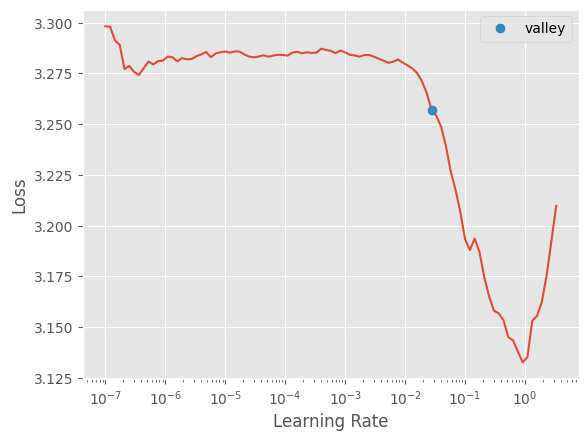

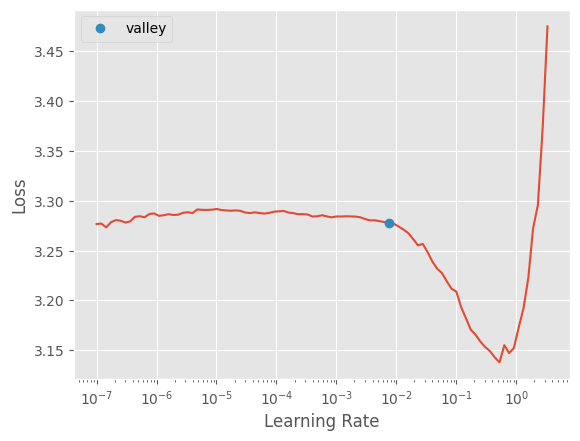

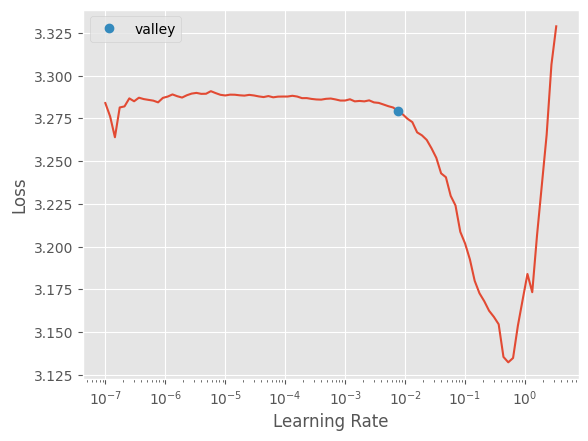

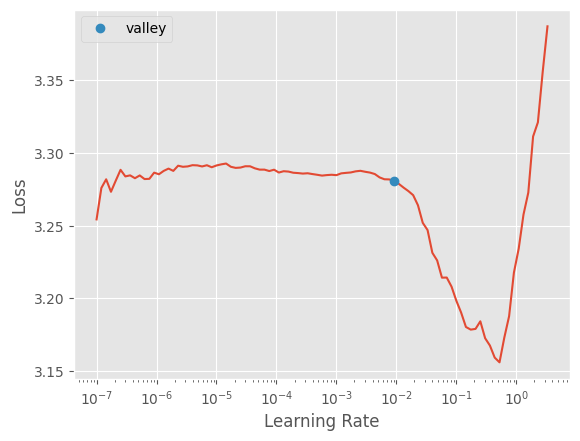

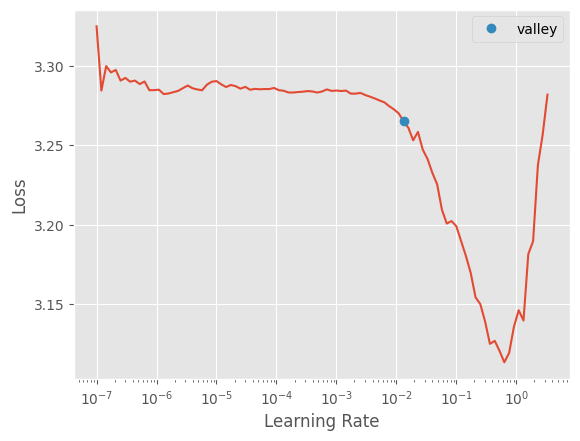

In [164]:
train_val = train_validate(dls,m,epoch=25,metrics=squeeze_accuracy,loss=squeeze_cross_entropy)

Load Test Log

In [165]:
#| export
def import_log_pdc(log):
    df = import_log(log)
    log = df.rename({"case:pdc:isPos":'normal'},axis=1,inplace=True)
    return df

In [166]:
test_log = import_log_pdc(f'../data/logs/csv/dapnn_ds/PDC2020_ground_truth/{log_name}.csv.gz')

test_log.head(25)

,activity,case:pdc:costs,normal,event_id
trace_id,,,,
trace 1,###start###,0.0,True,0
trace 1,t21,0.0,True,1
trace 1,t32,0.0,True,2
trace 1,t26,0.0,True,3
trace 1,t41,0.0,True,4
trace 1,t35,0.0,True,5
trace 1,t44,0.0,True,6
trace 1,t34,0.0,True,7
trace 1,t24,0.0,True,8


 Create PPOBJ of test data with same vocab

In [167]:
#| export
def process_test(test_log,categorify,cat_names='activity'):
    o=PPObj(test_log,procs=categorify,cat_names=cat_names,y_names=cat_names,do_setup=False)
    o.process()
    return o


In [168]:
o = process_test(test_log,categorify)

Apply Prediction Model

In [169]:
#| export
def predict_next_step(o,m,ws=5):
    wds,idx=partial(windows_fast,ws=ws)(o.xs, o.event_ids)
    res=(m(LongTensor(wds).cuda()))
    return res,idx

In [170]:
nsp,idx=predict_next_step(o,m)

In [177]:
nsp.shape

torch.Size([29095, 27])

Calculate Anomaly Score

In [171]:
#| export
def calc_anomaly_score(res,o,idx):
    sm = nn.Softmax(dim=1)
    y = o.items['activity'].iloc[idx].values
    p = sm(res)
    pred = p.max(1)[0]
    truth = p[list(range(0, len(y))),y]
    a_score = ((pred - truth) / pred).cpu().detach().numpy()
    return a_score

In [172]:
anomaly_score = calc_anomaly_score(nsp,o,idx)

Classify Anomalies based of Threshhold, get predictions and ground truth, compute a few metrics

In [173]:
#| export
def get_anomalies(a_score,o,idx,threshhold=0.98):
    df=pd.DataFrame(columns=[ 'a_score'])
    df['a_score'] = a_score
    df['trace_id'] = o.items.iloc[idx].index.values
    df['normal'] = o.items.iloc[idx]['normal'].values
    df

    y_true = (df.loc[df.trace_id.drop_duplicates().index].normal==False).tolist()
    cases = df.loc[df.trace_id.drop_duplicates().index].trace_id.tolist()
    anomalies = set(list(df.loc[df['a_score'] > threshhold]['trace_id']))
    y_pred=[case in anomalies for case in cases]
    return y_pred,y_true

In [174]:
y_pred, y_true = get_anomalies(anomaly_score,o,idx)

In [175]:
f1_score(y_true, y_pred)

0.8446139180171591

In [ ]:
accuracy_score(y_true, y_pred)

0.828

In [ ]:
precision_score(y_true,y_pred)

0.7289256198347107

In [ ]:
recall_score(y_true,y_pred)

0.9821826280623608

Get NSP Accuracy on Inrference

In [ ]:
#| export
def nsp_accuracy(o,idx,nsp):
    nsp_y=o.ys.iloc[idx]
    nsp_acc= accuracy(nsp,tensor(nsp_y.values).cuda())
    return nsp_acc

In [ ]:
nsp_accuracy(o,idx,nsp)

TensorBase(0.5081, device='cuda:0')

Rewrite model to support multivariate prediction. Define attr_dict that maps event log to considerable attributes. Dynamically adapt preprocessing, network architecture, loss function, and anomaly score computation

## Multivariate Anomaly Detection

In [ ]:
#| export
attr_dict={}
for i in [i for i in glob.glob('data/logs/csv/dapnn_ds/binet_logs/*')]:
    i=Path(i).stem[:-4]
    if 'bpic12'in i:
        attr_dict[i] =['activity']
    elif 'bpic13' in i:
        attr_dict[i]=['activity','org:group',
'org:resource', 'org:role', 'organization country', 'product', 'resource country','impact']
    elif 'bpic17' in i:  
        attr_dict[i]=['activity','EventOrigin','org:resource']
    elif 'bpic15' in i:
        attr_dict[i]=['activity', 'action_code', 'activityNameEN', 'activityNameNL','monitoringResource', 'org:resource', 'question']
    elif '-1' in i:
        attr_dict[i]=['activity','user']
    elif '-2' in i:
        attr_dict[i]=['activity','user','day']
    elif '-3' in i:
        attr_dict[i]=['activity','user','day','country']
    elif '-4' in i:
        attr_dict[i]=['activity','user','day','country','company']

In [ ]:
attr_dict

{'bpic15-0.3-4': ['activity',
  'action_code',
  'activityNameEN',
  'activityNameNL',
  'monitoringResource',
  'org:resource',
  'question'],
 'large-0.3-4': ['activity', 'user', 'day', 'country', 'company'],
 'small-0.3-4': ['activity', 'user', 'day', 'country', 'company'],
 'bpic13-0.3-3': ['activity',
  'org:group',
  'org:resource',
  'org:role',
  'organization country',
  'product',
  'resource country',
  'impact'],
 'medium-0.3-3': ['activity', 'user', 'day', 'country'],
 'medium-0.3-1': ['activity', 'user'],
 'bpic17-0.3-1': ['activity', 'EventOrigin', 'org:resource'],
 'wide-0.3-3': ['activity', 'user', 'day', 'country'],
 'large-0.3-2': ['activity', 'user', 'day'],
 'bpic17-0.3-2': ['activity', 'EventOrigin', 'org:resource'],
 'bpic13-0.3-1': ['activity',
  'org:group',
  'org:resource',
  'org:role',
  'organization country',
  'product',
  'resource country',
  'impact'],
 'small-0.3-3': ['activity', 'user', 'day', 'country'],
 'bpic12-0.3-1': ['activity'],
 'huge-0.3-2'

In [ ]:
#| export
def get_attr(attr_dict,log_name):
    if log_name in attr_dict: 
        return attr_dict[log_name]
    else: return ['activity']

In [ ]:
log_name= 'small-0.3-4'
fn=f'../data/logs/csv/dapnn_ds/binet_logs/{log_name}.csv.gz'
cols= get_attr(attr_dict,log_name)
cols

['activity', 'user', 'day', 'country', 'company']

In [ ]:
log = import_log(fn,cols)
log.head()

,activity,timestamp,timestamp_end,anomaly,company,country,day,user,event_id
trace_id,,,,,,,,,
1,###start###,NaN,NaN,normal,###start###,###start###,###start###,###start###,0
1,Activity A,NaN,NaN,normal,Toughzap,Peru,Monday,Sonia,1
1,Activity B,NaN,NaN,normal,Rundofase,Israel,Monday,Jack,2
1,Activity C,NaN,NaN,normal,Stanredtax,Saint Lucia,Monday,Earl,3
1,Activity D,NaN,NaN,normal,Condax,Ghana,Monday,Maryellen,4


In [ ]:
o,dls,categorify = training_dl(log,cols)

In [ ]:
xcat,ycat = dls.one_batch()
xcat.shape,ycat[0]

(torch.Size([32, 5, 5]),
 tensor([10,  3,  9, 12, 18, 18,  9,  3,  3,  1,  1,  7, 11,  1,  1,  1,  5,  6,
          1,  5,  8,  4, 17, 18,  3,  3,  4,  4, 13,  6, 21, 12],
        device='cuda:0'))

In [ ]:
emb_szs = get_emb_sz(o)

In [ ]:
fn=f'../data/logs/csv/dapnn_ds/binet_logs/{log_name}.csv.gz'

In [ ]:
#| export
class MultivariateModel(torch.nn.Module) :
    def __init__(self, emb_szs, lstm_neurons=25,lstm_layers=2) :
        super().__init__()
        
        self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.lstms = nn.ModuleList([nn.LSTM(nf, lstm_neurons, batch_first=True, num_layers=lstm_layers) 
                                    for ni,nf in emb_szs])
        self.linears = nn.ModuleList([nn.Linear(lstm_neurons, ni) for ni,nf in emb_szs])

        

    def forward(self, xcat):
        res=[]
        for i in range(xcat.shape[1]):
            x =xcat[:,i]
            x =self.embeds[i](x)
            x,_ =self.lstms[i](x)
            x = x[:,-1]
            x= self.linears[i](x)
            res.append(x)
        return tuple(res)
    


In [ ]:
m=MultivariateModel(emb_szs)
pred = m(xcat.cpu())
[i.shape for i in pred]

[torch.Size([32, 42]),
 torch.Size([32, 138]),
 torch.Size([32, 14]),
 torch.Size([32, 295]),
 torch.Size([32, 142])]

In [ ]:
#| export
def _accuracy_idx(a,b,i): return accuracy(listify(a)[i],listify(b)[i])

def get_metrics(o):
    
    number_cats=len(o.ycat_names)
    
    accuracies=[]
    for i in range(number_cats):
        accuracy_func=partial(_accuracy_idx,i=i)
        accuracy_func.__name__= f"acc_{o.ycat_names[i]}"
        accuracy_func=AvgMetric(accuracy_func)
        accuracies.append(accuracy_func)
    mae_days=None
    return L(accuracies)+mae_days

def multi_loss_sum(o,p,y):
    '''Multi Loss function that sums up multiple loss functions. The selection of the loss function is based on the PPObj o'''
    p,y=listify(p),listify(y)
    len_cat,len_cont=len(o.ycat_names),len(o.ycont_names)
    cross_entropies=[F.cross_entropy(p[i],y[i]) for i in range(len_cat)]
    return torch.sum(torch.stack(list(L(cross_entropies))))

def my_loss(p,y): return F.cross_entropy(p[0],y[0])
def my_metric(p,y): return accuracy(p[0],y[0])

In [ ]:
loss=partial(multi_loss_sum,o)

In [ ]:
loss(pred,[i.cpu() for i in ycat])

tensor(21.9264, grad_fn=<SumBackward0>)

In [ ]:
epoch=1
train_val=train_validate(dls,m,loss=loss,metrics=get_metrics(o),epoch=epoch,show_plot=False)


epoch,train_loss,valid_loss,_accuracy_idx,_accuracy_idx,_accuracy_idx,_accuracy_idx,_accuracy_idx,time
0,7.136340,7.045480,0.826224,0.544595,0.477460,0.553563,0.659477,00:32


Better model found at epoch 0 with valid_loss value: 7.045479774475098.


Better model found at epoch 0 with valid_loss value: 0.8068852424621582.


### Load Test Log for Inference

In [ ]:
log = import_log(fn)
log.head()
o = process_test(log,categorify,cols)

In [ ]:
#| export
def predict_next_step(o,m,ws=5):
    wds,idx=partial(windows_fast,ws=ws)(o.xs, o.event_ids)
    res= []
    with torch.no_grad():
        for b in DataLoader(wds,bs=8*1024,shuffle=False):
            h= m(b.long().cuda())
            h= tuple([i.cpu() for i in h])
            res.append(h)

    res =tuple([torch.cat([k[i] for k in res] ) for i in range(len(o.cat_names))])
    return res,idx

In [ ]:
%%time
res,idx=predict_next_step(o,m)


CPU times: user 1.18 s, sys: 183 ms, total: 1.36 s
Wall time: 315 ms


In [ ]:
#| export
def multivariate_anomaly_score(res,o,idx,cols):
    score_df=pd.DataFrame()

    for cidx,_ in enumerate(cols):
        sm = nn.Softmax(dim=1)
        p = sm(res[cidx].cpu())
        pred = p.max(1)[0]
        y = o.items[cols[cidx]].iloc[idx].values

        truth=p[list(range(len(y))),y]
        score = ((pred - truth) / pred).tolist()
        score_df[cols[cidx]] = score
    score_df['trace_id']=o.items.index.to_series().iloc[idx].values
    return score_df

In [ ]:
score_df=multivariate_anomaly_score(res,o,idx,cols)
score_df

,activity,user,day,country,company,trace_id
0,0.000000,0.439668,0.000000,0.531000,0.315139,1
1,0.000000,0.662233,0.000000,0.000000,0.000000,1
2,0.000000,0.380046,0.000000,0.532485,0.000000,1
3,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,0.000000,0.904819,0.362798,0.681615,0.828734,1
...,...,...,...,...,...,...
51690,0.000000,0.720104,0.537395,0.000000,0.000000,5000
51691,0.000000,0.000000,0.298893,0.097286,0.000000,5000
51692,0.989942,0.946027,0.391907,0.980420,0.982797,5000
51693,0.000000,0.345933,0.000000,0.867805,0.635300,5000


### Anomaly Classification

We can set a fixed threshold or define a custom threshold function. Currently only fixed threshold is used.

In [ ]:
#| export
def get_thresholds(col,act_threshold=0.964,attr_threshold=0.9971):
    """
    Defines a custom threshold function
    """
    if col =='activity':
        return act_threshold
    else: 
        return attr_threshold

In [ ]:
#| export
def multivariate_anomalies(score_df,cols,idx,o,anomaly_col='normal',fixed_threshold=None,get_thresholds=get_thresholds):
    if fixed_threshold is None:
        comp_thresholds=get_thresholds
    else:
        comp_thresholds = lambda _: fixed_threshold
    a=[score_df.loc[score_df[c] >= comp_thresholds(c)]['trace_id'] for c in cols]
    anomalies=list(set().union(*a))
    h=o.items.iloc[idx][anomaly_col]
    if anomaly_col=='anomaly':
        score_df['is_anomaly']=(h!='normal').tolist()
    else:
        score_df['is_anomaly']=(h==False).tolist()
    score_df['anomaly']=h.tolist()
    y_true = (score_df.loc[score_df.trace_id.drop_duplicates().index].is_anomaly).tolist()
    cases = score_df.loc[score_df.trace_id.drop_duplicates().index].trace_id.tolist()
    y_pred=[case in anomalies for case in cases]
    return y_true,y_pred

In [ ]:
y_true,y_pred=multivariate_anomalies(score_df,cols,idx,o,fixed_threshold=None,anomaly_col='anomaly')

In [ ]:
f1_score(y_true, y_pred)

0.851963746223565

In [ ]:
k=o.items.groupby(o.items.index)['anomaly'].last().iloc[np.where(~np.equal(y_pred, y_true))[0]
]
k.value_counts()

normal          371
SkipSequence     51
Attribute        32
Early            18
Late             18
Name: anomaly, dtype: int64

In [ ]:
o.items.groupby(o.items.index)['anomaly'].last().value_counts()

normal          3471
Rework           274
SkipSequence     268
Late             261
Early            253
Attribute        239
Insert           234
Name: anomaly, dtype: int64

## Plot Anomaly Scores for a Trace

In [ ]:
score_df['event_id']=score_df.groupby('trace_id').cumcount()

plot_data=score_df.melt(value_vars=['activity','user','day','country','company'],value_name='Anomaly Score',var_name='Attribute',id_vars=['trace_id','anomaly','event_id'])
plot_data['event_id']=plot_data.groupby('trace_id').cumcount()
plot_data

,trace_id,anomaly,event_id,Attribute,Anomaly Score
0,1,normal,0,activity,0.000000
1,1,normal,1,activity,0.000000
2,1,normal,2,activity,0.000000
3,1,normal,3,activity,0.000000
4,1,normal,4,activity,0.000000
...,...,...,...,...,...
258470,5000,SkipSequence,40,company,0.000000
258471,5000,SkipSequence,41,company,0.000000
258472,5000,SkipSequence,42,company,0.982797
258473,5000,SkipSequence,43,company,0.635300


In [ ]:
import seaborn as sns

45
SkipSequence
6


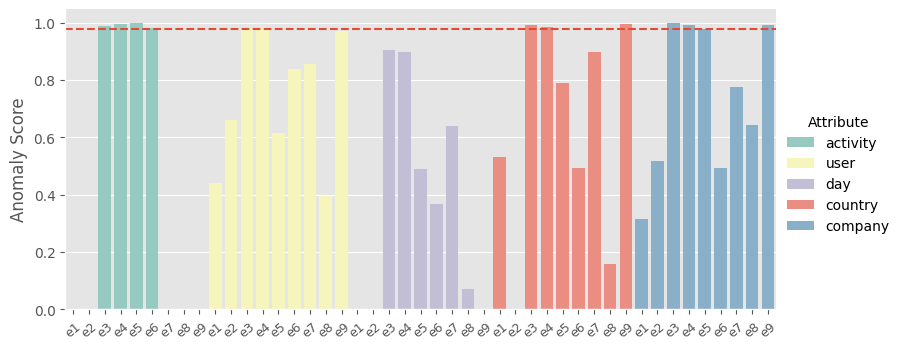

In [ ]:
data=plot_data[plot_data['trace_id']==6].copy()
data['xticks']= [f'e{y+1}' for x in range(5) for y in range(len(data)//5)]
print(len(data))
print(data['anomaly'].iloc[0])
print(data['trace_id'].iloc[0])
times = data.event_id.unique()
g = sns.FacetGrid(data, col="trace_id", hue="Attribute",
                  palette="Set3", height=4, aspect=2)
g.map(sns.barplot, 'event_id', 'Anomaly Score', order=times)
g.add_legend()
ax1 = g.axes[0][0]
g.set_titles(col_template="", row_template="")
g.set_axis_labels('')

ax1.axhline(0.98, ls='--')
for ax in g.axes.flat:
  
    ax.set_xticklabels([f'e{y+1}' for x in range(5) for y in range(len(data)//5)], rotation=40,fontsize=9) # set new labels
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')


In [ ]:
def plot_anomaly_scores(trace_id):
    data=plot_data[plot_data['trace_id']==trace_id]
    print(len(data))
    print(data['anomaly'].iloc[0])
    print(data['trace_id'].iloc[0])
    times = data.event_id.unique()
    g = sns.FacetGrid(data, col="trace_id", hue="Attribute",
                      palette="Set3", height=4, aspect=2)
    g.map(sns.barplot, 'event_id', 'Anomaly Score', order=times)
    g.add_legend()
    ax1 = g.axes[0][0]
    g.set_titles(col_template="", row_template="")
    g.set_axis_labels('')
    ax1.axhline(0.98, ls='--')
    for ax in g.axes.flat:

        ax.set_xticklabels([f'e{y+1}' for x in range(5) for y in range(len(data)//5)], rotation=50,fontsize=11) # set new labels
    plt.show()

40
normal
1


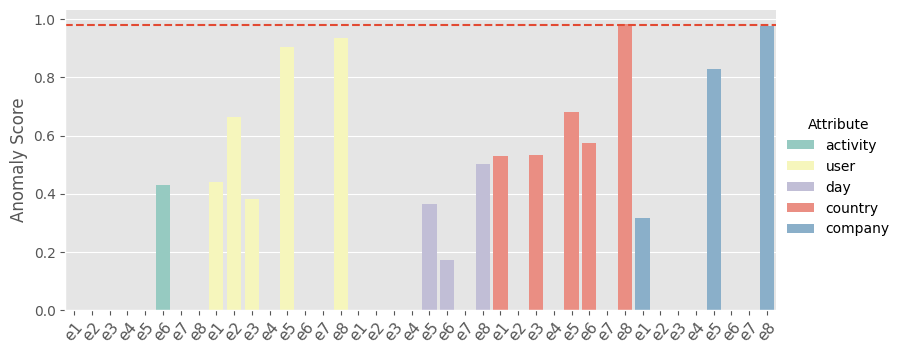

In [ ]:
plot_anomaly_scores(1)

45
SkipSequence
6


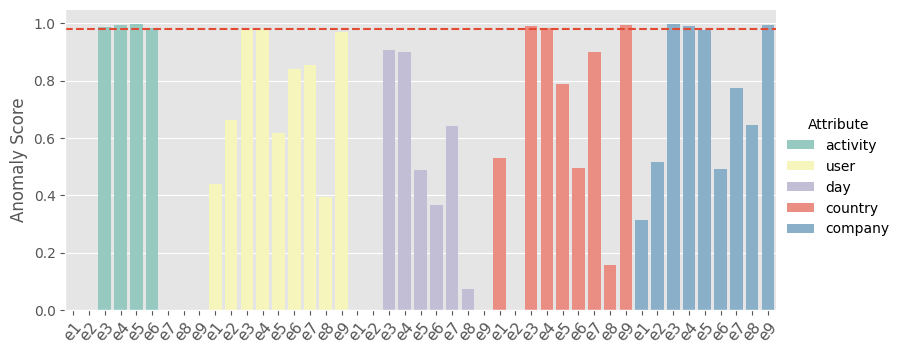

In [ ]:
plot_anomaly_scores(6)

## Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()